<h1 align="center">Lecture</h1>

## Активации из сетей для классификации, это хорошие признаки для изображений

<img src="img/act.png" width="800">


## Современные архитектуры очень глубокие , самые модные 

### VGG (стандартная архитектура, без наворотов)

<img src="img/vgg.png" width="600">

### ResNet (Shortcut + Batch Normalization)
 
<img src="img/resnet.png" width="800">
 
### GoogleNet (Много раз предсказываем классы на разных уровнях сети)

 
<img src="img/gln.png" width="800">


## Чем глубже слой тем более высокоуровневые признаки он детектирует

<img src="img/feat.png" width="800">

## На практике гораздо проще дообучать уже обученные сети (Fine-Tuning)

<img src="img/ft.jpg" width="600">

## Dark Magic 

<img src="img/dm.png" width="600">

# Сегодня Theano and Lasagne :)

<h1 align="center">Theano</h1>

```bash
pip install -U https://github.com/Theano/Theano/archive/master.zip
pip install -U https://github.com/Lasagne/Lasagne/archive/master.zip
```

### Разминка

In [1]:
import theano
import theano.tensor as T

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### будущий параметр функции -- символьная переменная

In [2]:
N = T.scalar('a dimension', dtype='float32')

#### рецепт получения квадрата -- орперации над символьными переменным

In [3]:
result = T.power(N, 2)

#### theano.grad(cost, wrt)

In [4]:
grad_result = theano.grad(result, N) 

#### компиляция функции "получения квадрата"

In [5]:
sq_function = theano.function(inputs=[N], outputs=result)
gr_function = theano.function(inputs=[N], outputs=grad_result)

#### применение функции

In [6]:
# Заводим np.array x
xv = np.arange(-10, 10)

# Применяем функцию к каждому x
val = map(float, [sq_function(x) for x in xv])

# Посичтаем градиент в кажой точке
grad = map(float, [gr_function(x) for x in xv])

### Что мы увидим если нарисуем функцию и градиент?

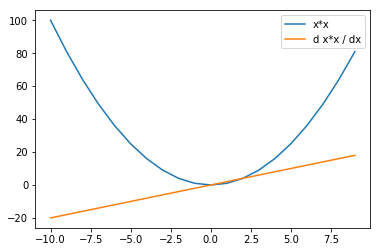

In [7]:
pylab.plot(xv, val, label='x*x')
pylab.plot(xv, grad, label='d x*x / dx')
pylab.legend()

### Как оно работает?
* почти всё, что есть в numpy есть в theano tensor и называется так же: `np.mean -> T.mean` и так далее...
* `theano.function` умеет за одно обновлять `shared` переменные по рецепту в `updates`
* Переменные нужно хранить в `shared` переменных, их можно менять после компиляции `theano.shared(np.ones(10))`

 
Ничего не понятно? Сейчас исправим.

### Теперь сам, LogReg

In [8]:
from sklearn import datasets
X_data, y_data = datasets.load_digits(2, return_X_y=True)

In [10]:
print 'y метки классов 0 или 1 [форма - %s]:' % (str(y_data.shape)),y_data[:10]
print 'X цифорки вытянутые в вектор [форма - %s]:' % (str(X_data.shape))
print X_data[0].reshape((8, 8))

 y метки классов 0 или 1 [форма - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X цифорки вытянутые в вектор [форма - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.]
 [  0.   0.  13.  15.  10.  15.   5.   0.]
 [  0.   3.  15.   2.   0.  11.   8.   0.]
 [  0.   4.  12.   0.   0.   8.   8.   0.]
 [  0.   5.   8.   0.   0.   9.   8.   0.]
 [  0.   4.  11.   0.   1.  12.   7.   0.]
 [  0.   2.  14.   5.  10.  12.   0.   0.]
 [  0.   0.   6.  13.  10.   0.   0.   0.]]


In [50]:
# переменные и входы
W = theano.shared(np.random.uniform(low=-0.1, high=0.1, size=X_data.shape[1]))
X = T.matrix('input batch')
y = T.vector('labels')

In [51]:
predicted_y = T.nnet.sigmoid(T.dot(X, W))
loss = - T.mean(np.dot(y, T.log(predicted_y)) + np.dot(1-y, T.log(1-predicted_y)))
grad = T.grad(loss, W)
updates = {W: W-0.1*grad}

In [52]:
train_function = theano.function([X, y], loss, updates=updates)
predict_function = theano.function([X], predicted_y)

In [53]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data)

 loss at iter 0:2.7092  train auc: 0.956156716418  test auc: 0.953063241107
 loss at iter 1:51.9870  train auc: 0.999945127305  test auc: 0.999011857708
 loss at iter 2:0.0643  train auc: 0.999945127305  test auc: 0.999505928854
 loss at iter 3:0.0464  train auc: 0.999945127305  test auc: 0.999505928854
 loss at iter 4:0.0375  train auc: 0.999945127305  test auc: 0.999505928854
resulting weights:


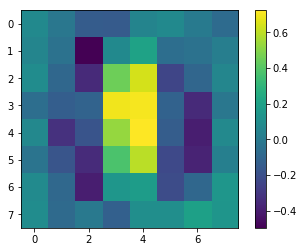

In [54]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train,y_train)
    print ' loss at iter %i:%.4f' % (i, loss_i),
    print ' train auc:', roc_auc_score(y_train, predict_function(X_train)),
    print ' test auc:', roc_auc_score(y_test, predict_function(X_test))
    
print ("resulting weights:")
plt.imshow(W.get_value().reshape(8,-1))
plt.colorbar()

<h1 align="center">Lasagne</h1>

* lasagne - это библиотека для написания нейронок произвольной формы на theano
* В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи, картинки 28x28, 10 цифр

In [2]:
from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print 'X размера', X_train.shape, 'y размера', y_train.shape

X размера (50000, 1, 28, 28) y размера (50000,)


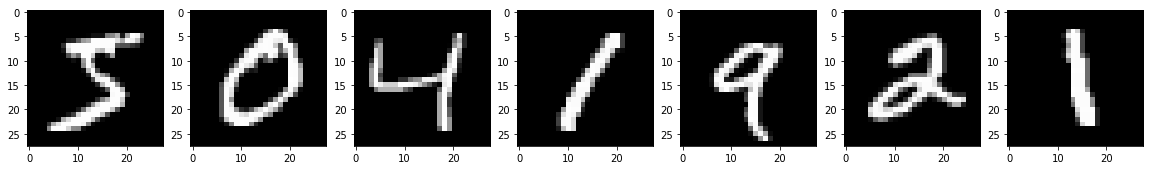

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 20))

for i, ax in enumerate(axes):
    ax.imshow(X_train[i, 0], cmap='gray')

Давайте посмотрим на DenseLayer в lasagne
- http://lasagne.readthedocs.io/en/latest/modules/layers/dense.html
- https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/dense.py#L16-L124 
- Весь содаржательный код тут https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/dense.py#L121 

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import softmax
from sklearn.preprocessing import OneHotEncoder
from lasagne import init

X, y = T.tensor4('X'), T.vector('y', 'int32')

Так задаётся архитектура нейронки

In [5]:
#входной слой (вспомогательный)
net = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=X)

net = lasagne.layers.Conv2DLayer(net, 16, 3, stride=2) # сверточный слой
net = lasagne.layers.Conv2DLayer(net, 10,  2)  # сверточный слой

net = lasagne.layers.DenseLayer(net, num_units=64) # полносвязный слой
net = lasagne.layers.DropoutLayer(net, 0.1)         # регуляризатор
net = lasagne.layers.DenseLayer(net, num_units=64) # полносвязный слой

net = lasagne.layers.DenseLayer(net, num_units=10, nonlinearity=softmax)  # полносвязный слой

In [9]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(net)
y_predicted_determ = lasagne.layers.get_output(net, deterministic=True)

In [10]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(net)
print all_weights

[W, b, W, b, W, b, W, b, W, b]


In [23]:
#функция ошибки и точности будет прямо внутри
loss = lasagne.objectives.categorical_crossentropy(y_predicted, y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, y).mean()
accuracy_fixed = lasagne.objectives.categorical_accuracy(y_predicted_determ, y).mean()

In [24]:
#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates = lasagne.updates.momentum(loss, all_weights, learning_rate=0.01, momentum=0.9)

In [25]:
#функция, делает updates и возвращащет значение функции потерь и точности
train_fun = theano.function([X, y], [loss, accuracy], updates=updates)
accuracy_fun = theano.function([X, y], accuracy_fixed) # точность без обновления весов, для теста

# Процесс обучения

In [26]:
import time
from mnist import iterate_minibatches

num_epochs = 10 #количество проходов по данным
batch_size = 100 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err, train_acc, train_batches = 0, 0, 0
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc, val_batches = 0, 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1
    
    # Then we print the results for this epoch:
    print('Epoch %s of %s took' % (epoch + 1, num_epochs))
    print('\t training loss:\t\t %.5f' % (train_err / train_batches))
    print('\t train accuracy:\t %s' % (train_acc / train_batches * 100))
    print('\t validation accuracy:\t %s' % (val_acc / val_batches * 100))

Epoch 1 of 10 took
	 training loss:		 0.04696
	 train accuracy:	 98.476
	 validation accuracy:	 98.14
Epoch 2 of 10 took
	 training loss:		 0.04294
	 train accuracy:	 98.578
	 validation accuracy:	 98.29
Epoch 3 of 10 took
	 training loss:		 0.03968
	 train accuracy:	 98.684
	 validation accuracy:	 98.27
Epoch 4 of 10 took
	 training loss:		 0.03656
	 train accuracy:	 98.776
	 validation accuracy:	 98.23
Epoch 5 of 10 took
	 training loss:		 0.03441
	 train accuracy:	 98.874
	 validation accuracy:	 98.23
Epoch 6 of 10 took
	 training loss:		 0.03083
	 train accuracy:	 98.934
	 validation accuracy:	 98.36
Epoch 7 of 10 took
	 training loss:		 0.02793
	 train accuracy:	 99.042
	 validation accuracy:	 98.27
Epoch 8 of 10 took
	 training loss:		 0.02703
	 train accuracy:	 99.05
	 validation accuracy:	 98.26
Epoch 9 of 10 took
	 training loss:		 0.02366
	 train accuracy:	 99.158
	 validation accuracy:	 98.35
Epoch 10 of 10 took
	 training loss:		 0.02306
	 train accuracy:	 99.232
	 validati

In [28]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results: \n test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

Final results: 
 test accuracy:		98.26 %


# не забывайте оставлять отзывы 
# о лекции https://goo.gl/gMeYNL о семинаре https://goo.gl/5hlPD0 :)